In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives
gIs   = 1./7            # removal rate of asymptomatic infectives
gE = 0.1
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 200
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}

# use pyross stochastic to generate traj and save 

sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data=sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

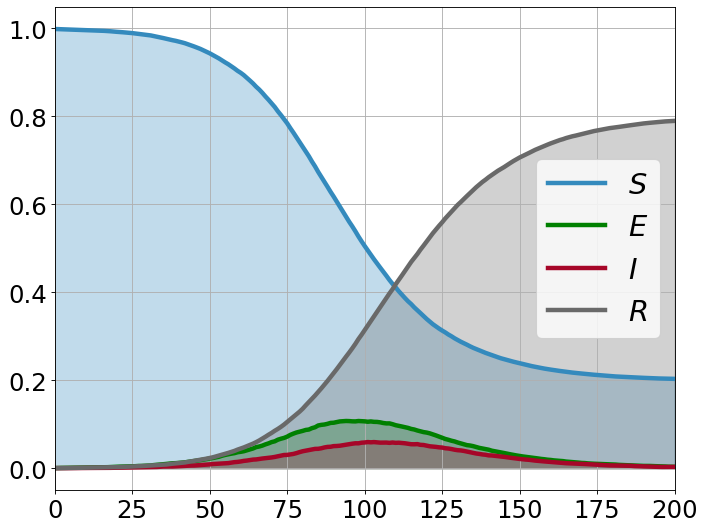

In [3]:
# plot the data and obtain the epidemic curve for one age group 

S  = np.sum( data['X'][:,0*M:1*M],axis=-1)
E  = np.sum( data['X'][:,1*M:2*M],axis=-1)
Ia = np.sum( data['X'][:,2*M:3*M],axis=-1)
Is = np.sum( data['X'][:,3*M:4*M],axis=-1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)


plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R= np.sum(Ni)-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

# Infer parameters based on part of the trajectory

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-1404.6095040778982
0.1332862377166748


In [12]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.3
alpha_std = 0.2
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.1 
beta_bounds = (eps, 1)

gIa_g = 0.1
gIa_std = 0.2 
gIa_bounds = (eps, 1)

gIs_g = 0.1
gIs_std = 0.2
gIs_bounds = (eps, 1)

gE_g = 0.2
gE_std = 0.2 
gE_bounds = (eps, 1)

keys = ['alpha', 'beta', 'gIa', 'gIs', 'gE']

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds])

start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, contactMatrix, 
                                    tangent=False,
                                    global_max_iter=20,
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=161688664, Wed May 20 22:19:43 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.208737554229710e+03 1.0e+00 9.14e-01  8e-02  2e-01 0:01.4
    2     32 -1.398122532491150e+03 1.4e+00 9.27e-01  8e-02  2e-01 0:03.0
    3     48 -1.282078471093503e+03 1.6e+00 9.49e-01  8e-02  2e-01 0:04.4
    6     96 -1.344404545166607e+03 2.2e+00 9.54e-01  7e-02  2e-01 0:07.8
   10    160 -1.292175793642839e+03 2.2e+00 8.37e-01  6e-02  2e-01 0:12.7
   15    240 -1.326969474247104e+03 3.1e+00 5.10e-01  3e-02  1e-01 0:18.6
Optimal value (global minimisation):  -1405.5622715207624
Starting local minimisation...
Optimal value (local minimisation):  -1411.2478432316243
[0.21945222 0.02050736 0.14662685 0.13163602 0.09397345]
30.84394907951355


In [13]:
hessian = estimator.hessian(params, guess, stds,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [14]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],
              'fsa':fsa,
             'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEIR(parameters, M, Ni)

In [15]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
E0_forecast = x[-1,M:2*M]*N
Ia0_forecast = x[-1,2*M:3*M]*N
Is0_forecast = x[-1,3*M:]*N

# Number of simulations over which we average, use 500
Ns = 10 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, E0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:02


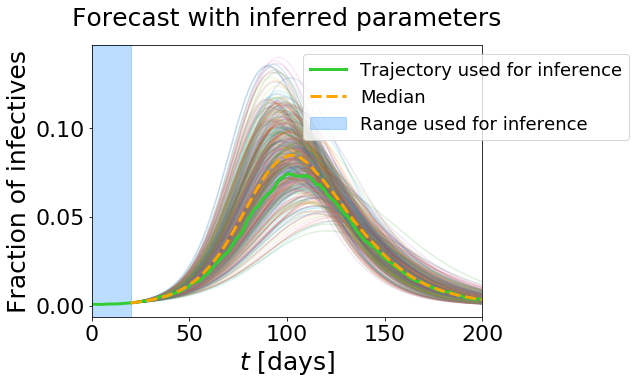

In [16]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show()
plt.close()